In [1]:
import pandas as pd
import numpy as np
from itertools import combinations_with_replacement, product
import tqdm
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from pymutspec.constants import possible_sbs192_set
from scipy import spatial

import warnings
warnings.filterwarnings("ignore")


### Table with calculated mutspec for species in CytB

In [2]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [3]:
mut = pd.read_csv('../data/new_dataset/MutSpecVertebrates192.csv.gz')
mut = mut[mut.Gene == 'Cytb']
mut['Mut'] = mut.Mut.apply(getrevers)
mut["MutBase"] = mut.Mut.str.slice(2, 5)
mut["Context"] = mut.Mut.str.get(0) + mut.Mut.str.get(2) + mut.Mut.str.get(-1)
mut.head()

,Gene,Class,Species,Mut,Observed,Expected,MutSpec,MutBase,Context
39552,Cytb,Mammalia,Tarsius_dentatus,T[T>G]T,NaN,0.00,0.0,T>G,TTT
39553,Cytb,Mammalia,Tarsius_dentatus,G[T>G]T,NaN,0.00,0.0,T>G,GTT
39554,Cytb,Mammalia,Tarsius_dentatus,C[T>G]T,NaN,0.00,0.0,T>G,CTT
39555,Cytb,Mammalia,Tarsius_dentatus,A[T>G]T,NaN,0.00,0.0,T>G,ATT
39556,Cytb,Mammalia,Tarsius_dentatus,T[T>G]G,NaN,11.95,0.0,T>G,TTG


### Cancer df
Each raw represents patien with mutspec of cancer, only syn mutations


In [4]:
canc_df = pd.read_csv('../data/human_cancer_spectra_patient_specific_syn.csv')
canc_df = canc_df.drop(['nobs'], axis=1)
canc_df.head()

,sample,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,A[G>A]A,...,T[G>A]C,T[G>A]G,T[G>A]T,T[G>C]C,T[G>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]G
0,0007_CRUK_PC_0007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0064_CRUK_PC_0064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.009524,0.0,0.0,0.0,0.0
2,0071_CRUK_PC_0071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0078b0c4-68a9-483b-9aab-61156d263213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0082_CRUK_PC_0082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### Insert non described sbs

In [5]:
for sbs in possible_sbs192_set:
    if sbs not in canc_df.columns:
        canc_df[sbs] = 0

### Format as MutSpec

In [6]:
canc_df = canc_df.melt(id_vars=['sample'], value_vars=canc_df.columns[1:])\
    .sort_values(by=['sample']).reset_index(drop=True)
canc_df = canc_df.rename(columns={'variable': 'Mut', 'value': 'MutSpec'})
canc_df['Class'] = 'Cancer'
canc_df['Mut'] = canc_df.Mut.apply(getrevers)
canc_df['MutBase'] = canc_df['Mut'].str.get(2) + '>' + canc_df['Mut'].str.get(4)
canc_df.head()

,sample,Mut,MutSpec,Class,MutBase
0,0007_CRUK_PC_0007,T[T>C]T,0.0,Cancer,T>C
1,0007_CRUK_PC_0007,A[C>A]C,0.0,Cancer,C>A
2,0007_CRUK_PC_0007,C[T>A]C,0.0,Cancer,T>A
3,0007_CRUK_PC_0007,A[T>C]C,0.0,Cancer,T>C
4,0007_CRUK_PC_0007,C[T>G]T,0.0,Cancer,T>G


### Create vectors of orderds in heatmap and combinations

In [7]:
cl_vec = list(mut['Class'].drop_duplicates()) + ['Cancer']
correct_order = ["Actinopteri","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]

## Similarity JackKnife

Here is a function Jackknife for cosine similarity analysis. Every time we take randomly 20 species from each class and than calculate mutpsec for each class presented by those 20 species. Next do cosine similarity analysis.

In [8]:
TS_vec = ['A>G', 'G>A', 'T>C', 'C>T']
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

def get_similarity_table(mut_df: pd.DataFrame, canc_df: pd.DataFrame, mut_type='all', n_iter=100, save_file_path=''):

    correct_order = ["Actinopteri","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]

    to_heatmap = []

    if mut_type == 'TS':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TS_vec)].copy()
        canc_df = canc_df[canc_df['MutBase'].isin(TS_vec)].copy()
    elif mut_type == 'TV':
        mut_to_cos = mut_df[mut_df['MutBase'].isin(TV_vec)].copy()
        canc_df = canc_df[canc_df['MutBase'].isin(TV_vec)].copy()
    elif mut_type =='all':
        mut_to_cos = mut_df.copy()
    else:
        raise('Error, try another MutType')
    
    possible_comp = list(combinations_with_replacement(correct_order, 2))

    for comp in possible_comp:
       
        cls1 = comp[0]
        cls2 = comp[1]
        
        for _ in range(0, n_iter):

            if cls1 != 'Cancer':
                
                df1_sps = mut_to_cos[mut_to_cos['Class'] == cls1]['Species']\
                    .drop_duplicates().sample(n=50, replace=False)
                df1 = mut_to_cos[mut_to_cos['Species'].isin(df1_sps)].groupby('Mut')\
                .MutSpec.mean().reset_index() # normolization by mean in each mut with context
                
            else:

                df1_sps = canc_df['sample'].drop_duplicates()\
                    .sample(frac=.5, replace=False)
                df1 = canc_df[canc_df['sample'].isin(df1_sps)].groupby('Mut')\
                    .MutSpec.mean().reset_index()

            if cls2 != 'Cancer':
                df2_sps = mut_to_cos[mut_to_cos['Class'] == cls2]['Species']\
                    .drop_duplicates().sample(n=50, replace=False)
                df2 = mut_to_cos[mut_to_cos['Species'].isin(df2_sps)].groupby('Mut')\
                    .MutSpec.mean().reset_index()
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])

            else:
                df2_sps = canc_df['sample'].drop_duplicates()\
                    .sample(frac=.5, replace=False)
                df2 = canc_df[canc_df['sample'].isin(df2_sps)].groupby('Mut')\
                    .MutSpec.mean().reset_index()
                cos192 = spatial.distance.cosine(df1['MutSpec'], df2['MutSpec'])
                
            cos_res = {'Class1':cls1, 'Class2':cls2, 'Similarity':1-cos192}
            to_heatmap.append(cos_res)

            
    
    # ! in comm as we want to draw only half
    ### make a mirror form copied df for hetmap input
    #to_heatmap = pd.DataFrame(to_heatmap)
    #heatmap_copied = to_heatmap.copy().rename(columns={'Class1': 'Class2', 'Class2': 'Class1'})
    #res_fnl = pd.concat([to_heatmap, heatmap_copied]).drop_duplicates(['Class1', 'Class2', 'Similarity'])
    
    if save_file_path != '':
        pd.DataFrame(to_heatmap).to_csv(save_file_path, index=False)

    return pd.DataFrame(to_heatmap)

### Function to get Quantiles for each comparison btw classes

In [9]:
def get_quantiles_annot(heatmap_table: pd.DataFrame):
    
    correct_order = ["Actinopteri", "Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]  # make order of out df

    # Calculate quantiles for each combination of classes
    heatmap_table = heatmap_table.groupby(['Class1', 'Class2']).quantile([.25,.5,.75]).reset_index()
    heatmap_table['Similarity'] = heatmap_table['Similarity'].round(2)

    
    # Transform results to 2D array for annotating heatmap 
    out_quantile_annot = pd.DataFrame(np.nan, index= correct_order, columns = correct_order)
    
    for row_comb in range(0,len(heatmap_table),3):
        res_txt = []
        sampl = heatmap_table.iloc[row_comb:row_comb+3,:]
        cls1 = sampl.iloc[0,0]
        cls2 = sampl.iloc[0,1]
        res_txt.append(str(sampl.iloc[2,3]) + '\n' + str(sampl.iloc[1,3]) + '\n' + str(sampl.iloc[0,3]))
    
        out_quantile_annot[cls1][cls2] = ''.join(res_txt)

    return out_quantile_annot

### Function to draw Heatmap

In [10]:
def heatmap_similaruty(
        inp_heatmap: pd.DataFrame, save_path='', 
        title='Similarity of mutational spectrum', titlesize=32,
        col_ht='white', cmap="crest", fontsize=18, labels_fontsize=18,
        vmin=None, vmax=1, ax=None, show_quartiles=True, cbar=False,
    ):
    
    if show_quartiles:
        # Calculate quantiles for annot
        annot = get_quantiles_annot(inp_heatmap)
        fmt = ''
    else:
        annot = True
        fmt = '.2f'

    # reshape input data to heatmap format
    #inp_heatmap.loc[inp_heatmap['Class1'] == inp_heatmap['Class2'], 'Similarity'] = np.nan
    all_heatmap = inp_heatmap.groupby(['Class1', 'Class2']).median()\
        .reset_index().pivot('Class2', 'Class1', 'Similarity') 
    all_heatmap.index = pd.CategoricalIndex(all_heatmap.index, categories=correct_order)
    all_heatmap.sort_index(axis=0, inplace=True)
    all_heatmap = all_heatmap.reindex(correct_order, axis=1)

    # Plot heatmap
    if ax is None:
        plt.figure(figsize=(12, 12))

    ax = sns.heatmap(all_heatmap, cmap=cmap, vmin=vmin, vmax=vmax, annot=annot, cbar=cbar,
                      annot_kws={"size": fontsize, 'color': col_ht, 'font': 'Arial'}, 
                      cbar_kws={'label': 'Cosine similarity',
                                'aspect': 20},
                      fmt=fmt, linewidths=5, linecolor='white', square=True, ax=ax)
    ax.tick_params(left=False, bottom=False)
    ax.set(xlabel="", ylabel="")
    ax.set_title(title, fontsize=titlesize)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=labels_fontsize)
    
    
    if save_path != '':
        plt.savefig(save_path, dpi=400, bbox_inches='tight')


correct_order = ["Actinopteri","Amphibia", "Lepidosauria", "Mammalia", "Aves", "Cancer"]

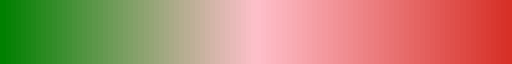

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors. Each color is given as a tuple of RGB values, which range from 0 to 1.
colors = ["green", "pink", '#d73027']  # You can also use hexadecimal colors or RGB tuples.
n_bins = 100  # Use more bins to get a smoother transition

# Create the colormap
cmap_name = 'custom_cmap'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins, gamma=1)
custom_cmap

### JackKnife for all mutations

In [147]:
get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='all', n_iter=1000, save_file_path='../data/CosSimAll.csv')

,Class1,Class2,Similarity
0,Actinopteri,Actinopteri,0.959175
1,Actinopteri,Actinopteri,0.902595
2,Actinopteri,Actinopteri,0.920997
3,Actinopteri,Actinopteri,0.949182
4,Actinopteri,Actinopteri,0.930373
...,...,...,...
20995,Cancer,Cancer,0.906583
20996,Cancer,Cancer,0.885090
20997,Cancer,Cancer,0.931835
20998,Cancer,Cancer,0.962249


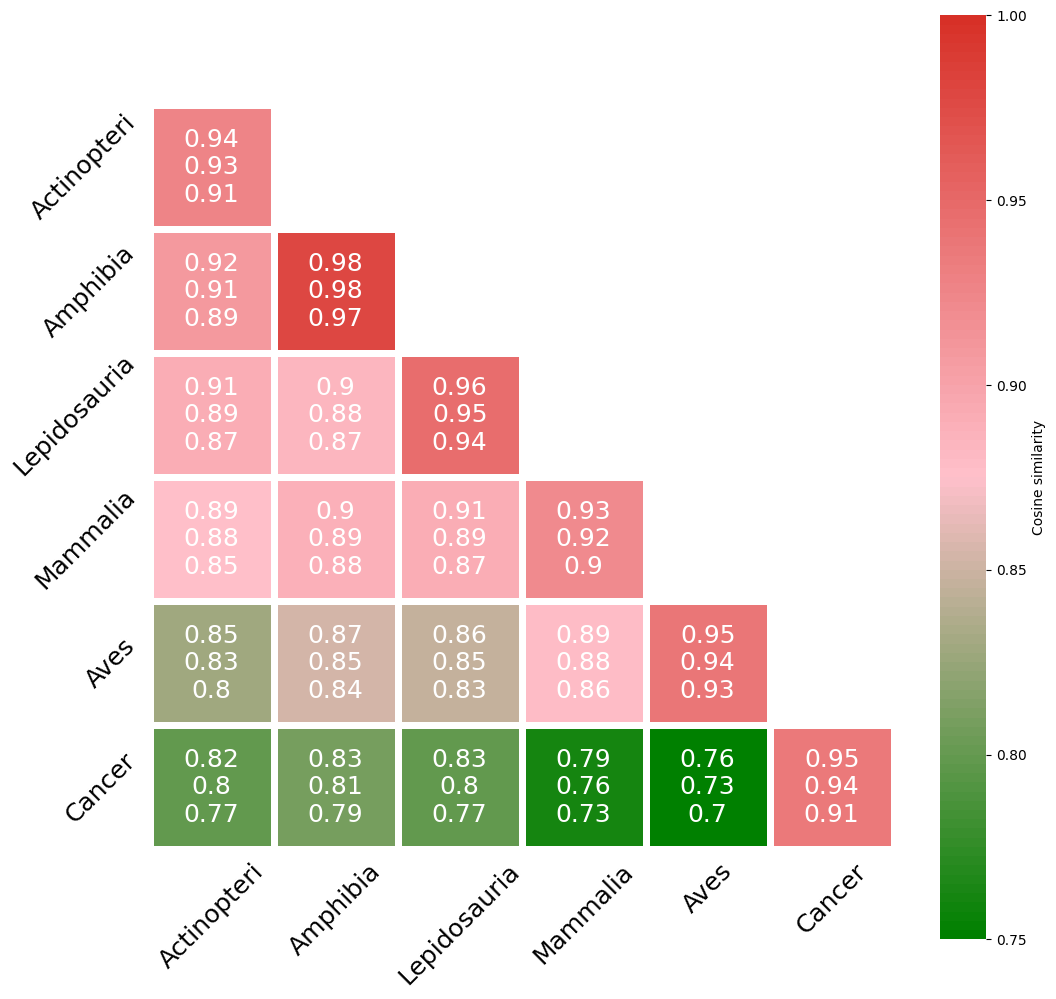

In [168]:
to_heatmap = pd.read_csv('../data/CosSimAll.csv')

heatmap_similaruty(
    to_heatmap, title='', 
    save_path='../pictures/HeatmapJack/Jackknife_Similarity.pdf',
    # fontsize=36, labels_fontsize=28, titlesize=42, 
    vmin=0.75, vmax=1, cmap=custom_cmap, col_ht='w', cbar=True)

### JackKnife for transitions only

In [149]:
get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TS', n_iter=1000, save_file_path='../data/CosSimTS.csv')

,Class1,Class2,Similarity
0,Actinopteri,Actinopteri,0.932266
1,Actinopteri,Actinopteri,0.918335
2,Actinopteri,Actinopteri,0.907520
3,Actinopteri,Actinopteri,0.949455
4,Actinopteri,Actinopteri,0.956530
...,...,...,...
20995,Cancer,Cancer,0.933894
20996,Cancer,Cancer,0.865910
20997,Cancer,Cancer,0.906021
20998,Cancer,Cancer,0.917604


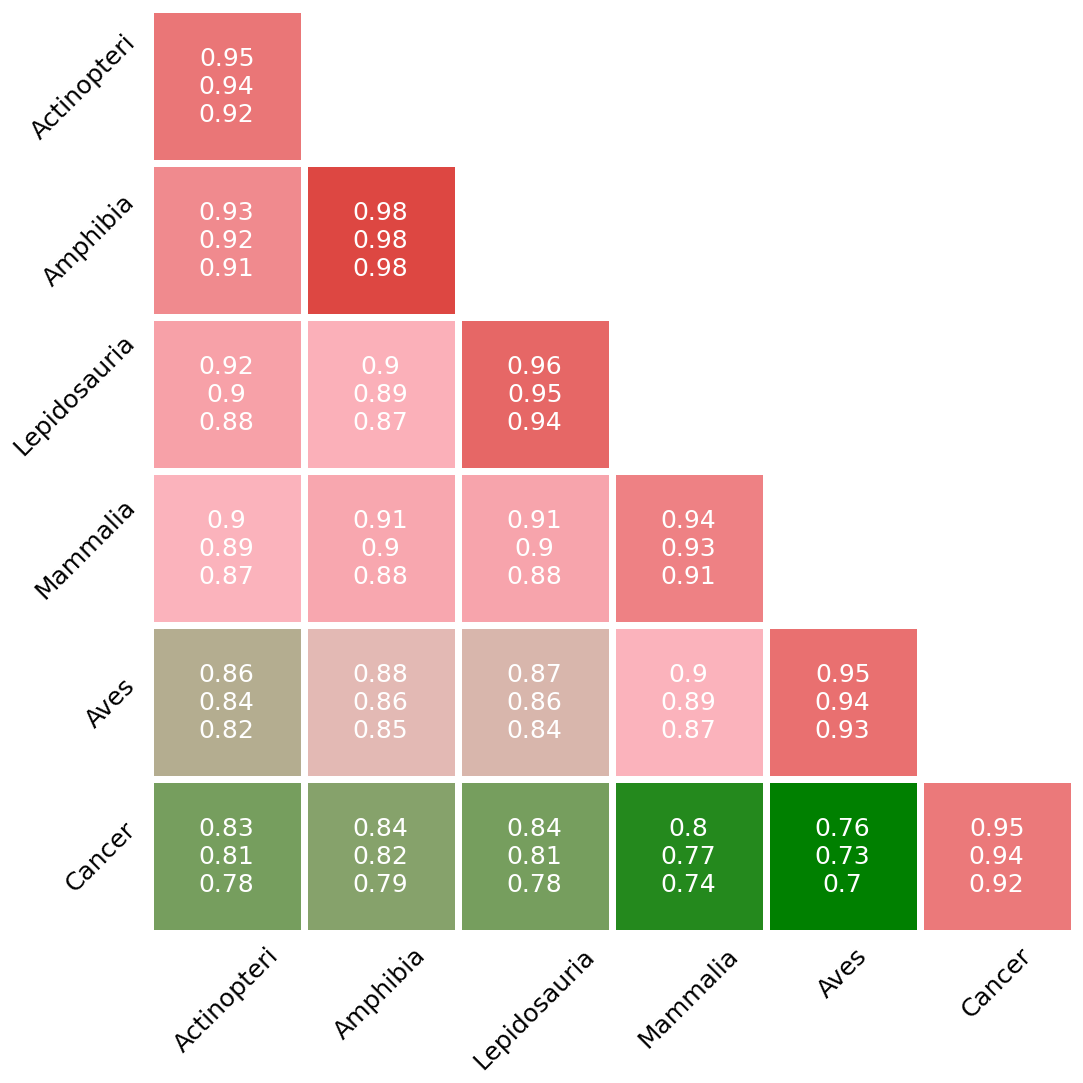

In [159]:
to_heatmap = pd.read_csv('../data/CosSimTS.csv')

heatmap_similaruty(
    to_heatmap, title='', 
    save_path='../pictures/HeatmapJack/Jackknife_SimilarityTS.pdf',
    # fontsize=36, labels_fontsize=28, titlesize=42, 
    vmin=0.75, vmax=1, cmap=custom_cmap, col_ht='w')

### JackKnife for transversions only

In [151]:
get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='TV', n_iter=1000, save_file_path='../data/CosSimTV.csv')

,Class1,Class2,Similarity
0,Actinopteri,Actinopteri,0.563680
1,Actinopteri,Actinopteri,0.520732
2,Actinopteri,Actinopteri,0.520327
3,Actinopteri,Actinopteri,0.455495
4,Actinopteri,Actinopteri,0.477778
...,...,...,...
20995,Cancer,Cancer,0.716489
20996,Cancer,Cancer,0.290084
20997,Cancer,Cancer,0.730527
20998,Cancer,Cancer,0.645157


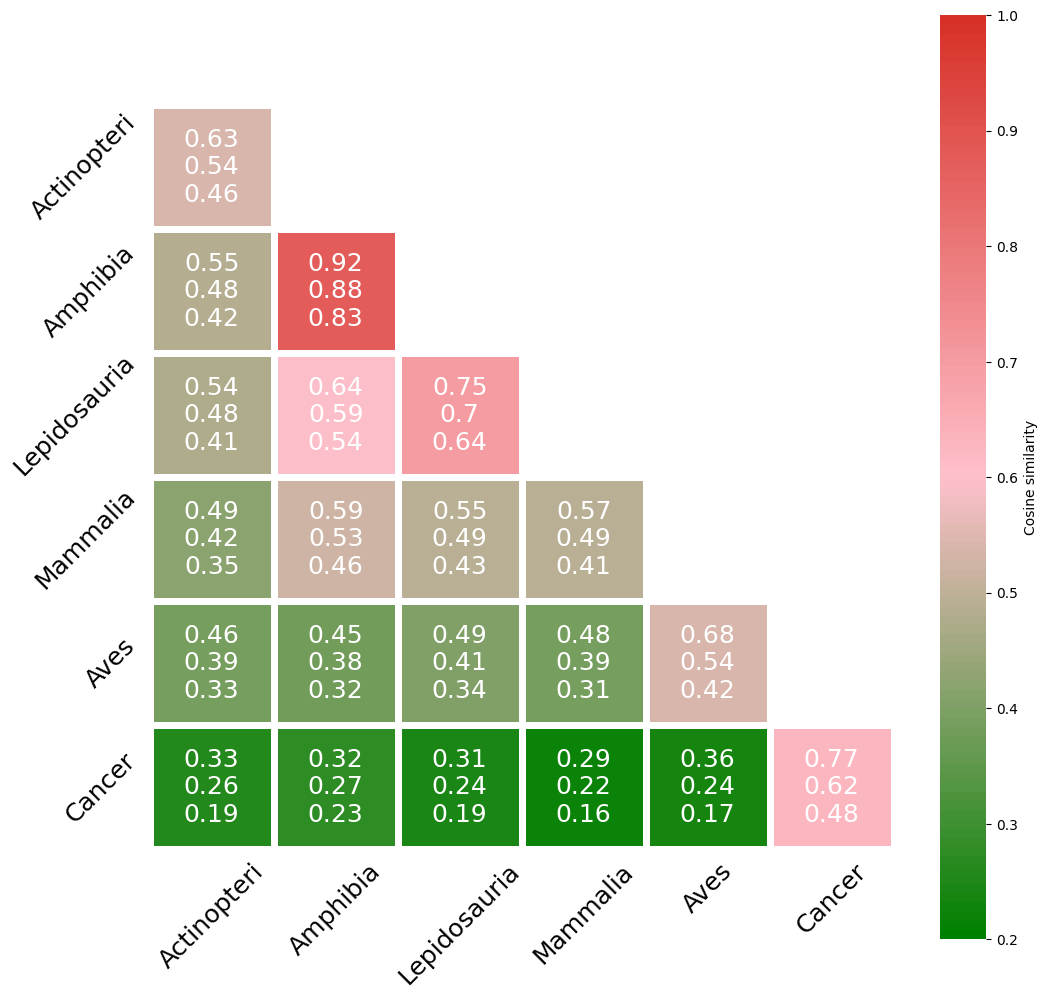

In [169]:
to_heatmap = pd.read_csv('../data/CosSimTV.csv')
heatmap_similaruty(
    to_heatmap, title='', 
    save_path='../pictures/HeatmapJack/Jackknife_SimilarityTV.pdf',
    # fontsize=36, labels_fontsize=28, titlesize=42, 
    vmin=0.2, vmax=1, cmap=custom_cmap, col_ht='w', cbar=True)

### Jackknife for 4 types of substituion in transitions only!

In [16]:
vec_of_subs_het = ['C>T', 'A>G', 'G>A', 'T>C']

In [ ]:
TS_cancer = canc_df[canc_df['MutBase'].isin(TS_vec)]
TS_df = mut[mut['MutBase'].isin(TS_vec)].copy()
for sub in vec_of_subs_het:
    needed_subs_df = TS_df[TS_df['MutBase'] == sub]
    cancer_needed_subs = TS_cancer[TS_cancer['MutBase'] == sub]
    get_similarity_table(mut_df=needed_subs_df, canc_df=cancer_needed_subs, mut_type='all', n_iter=1000, save_file_path=f'../data/CosSim{sub}.csv')

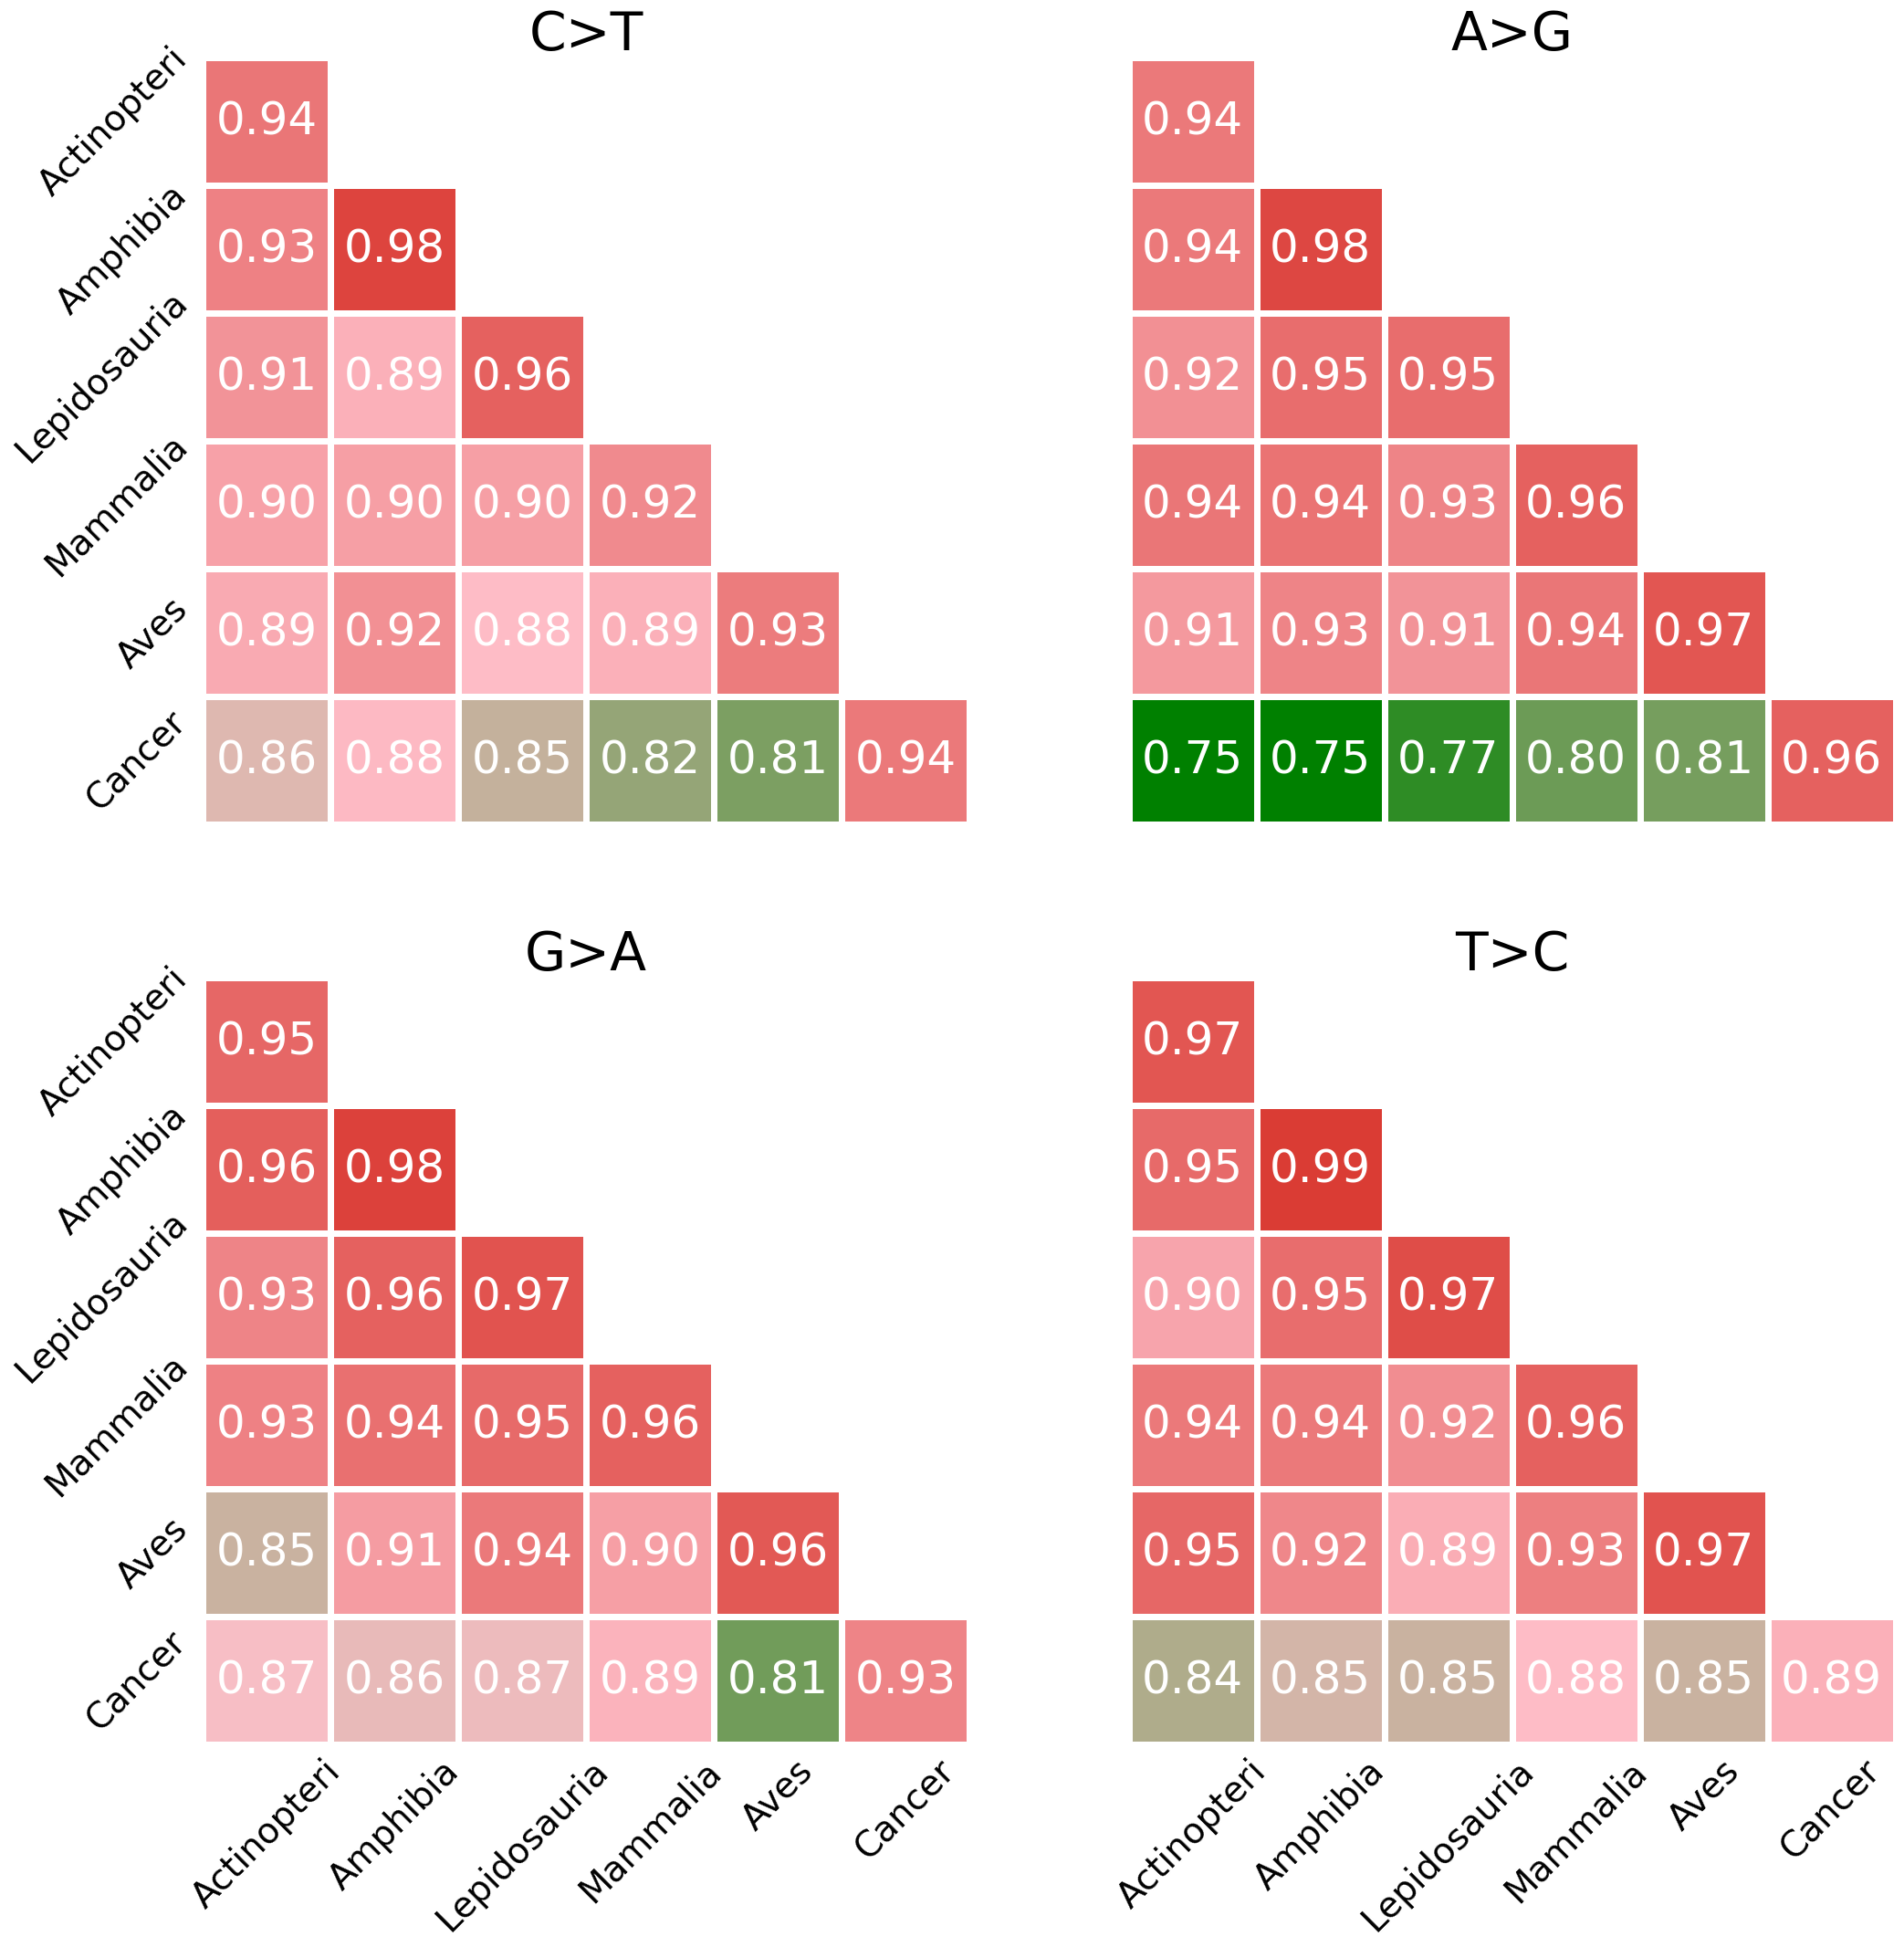

In [150]:
fig, axes = plt.subplots(2, 2, )
# fig.tight_layout()
fig.set_size_inches(24, 24)

for sub, ax in zip(vec_of_subs_het, axes.flatten()):
    to_heatmap = pd.read_csv(f'../data/CosSim{sub}.csv')
    heatmap_similaruty(
        to_heatmap, title=sub, ax=ax, show_quartiles=False, 
        fontsize=36, labels_fontsize=28, titlesize=42, 
        vmin=0.75, vmax=1, cmap=custom_cmap, col_ht='w')
    if sub in ['C>T', 'A>G']:
        ax.set_xticklabels([])
    if sub in ['T>C', 'A>G']:
        ax.set_yticklabels([])
plt.savefig('../pictures/HeatmapJack/Jackknife_SimilarityTS_Separate.pdf', 
            bbox_inches='tight')

### Cossim btw samples and whole class-specific spectra

In [155]:
mut.head()

,Gene,Class,Species,Mut,Observed,Expected,MutSpec,MutBase,Context
39552,Cytb,Mammalia,Tarsius_dentatus,T[T>G]T,NaN,0.00,0.0,T>G,TTT
39553,Cytb,Mammalia,Tarsius_dentatus,G[T>G]T,NaN,0.00,0.0,T>G,GTT
39554,Cytb,Mammalia,Tarsius_dentatus,C[T>G]T,NaN,0.00,0.0,T>G,CTT
39555,Cytb,Mammalia,Tarsius_dentatus,A[T>G]T,NaN,0.00,0.0,T>G,ATT
39556,Cytb,Mammalia,Tarsius_dentatus,T[T>G]G,NaN,11.95,0.0,T>G,TTG


In [156]:
canc_df.head()

,sample,Mut,MutSpec,Class,MutBase
0,0007_CRUK_PC_0007,T[T>C]T,0.0,Cancer,T>C
1,0007_CRUK_PC_0007,A[C>G]T,0.0,Cancer,C>G
2,0007_CRUK_PC_0007,C[T>A]C,0.0,Cancer,T>A
3,0007_CRUK_PC_0007,A[T>C]C,0.0,Cancer,T>C
4,0007_CRUK_PC_0007,C[A>C]T,0.0,Cancer,A>C


In [158]:
cossim_cls_smpl = []

for cls in tqdm.tqdm(correct_order):

    if cls != 'Cancer':
        cls_df = mut[mut.Class == cls].copy()
        
    else:
        cls_df = canc_df.copy()
        
    cls_mean_mut = cls_df.groupby('Mut').MutSpec.mean().reset_index()

    for _ in range(1000):

        if cls != 'Cancer':
            smpl_sps = cls_df['Species']\
                    .drop_duplicates().sample(n=50, replace=False)
            smpl_mean_mut = cls_df[cls_df['Species'].isin(smpl_sps)].groupby('Mut')\
            .MutSpec.mean().reset_index()
            
            
        else:
            smpl_sps = canc_df['sample']\
                    .drop_duplicates().sample(frac=.5, replace=False)
            smpl_mean_mut = cls_df[cls_df['sample'].isin(smpl_sps)].groupby('Mut')\
            .MutSpec.mean().reset_index()
            
        cos192 = spatial.distance.cosine(cls_mean_mut['MutSpec'], smpl_mean_mut['MutSpec'])
        cos_res = {'Class':cls, 'Similarity':1-cos192}
        cossim_cls_smpl.append(cos_res)

cossim_cls_smpl = pd.DataFrame(cossim_cls_smpl)

100%|██████████| 6/6 [00:22<00:00,  3.76s/it]


In [159]:
cossim_cls_smpl.head()

,Class,Similarity
0,Actinopteri,0.967598
1,Actinopteri,0.947013
2,Actinopteri,0.972778
3,Actinopteri,0.972011
4,Actinopteri,0.959289


<AxesSubplot:xlabel='Class', ylabel='Similarity'>

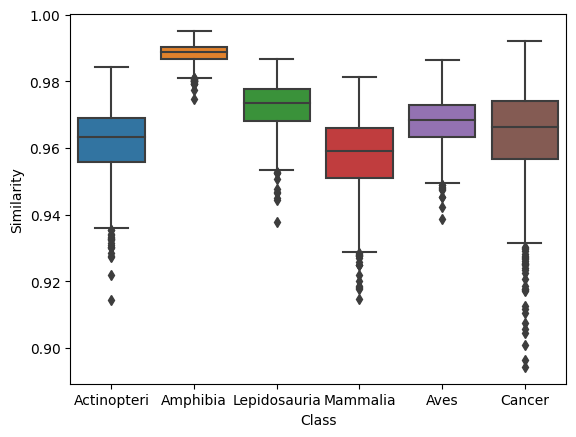

In [160]:
sns.boxplot(cossim_cls_smpl, x='Class', y='Similarity')

### KDE plots for the base subs

Sub: 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


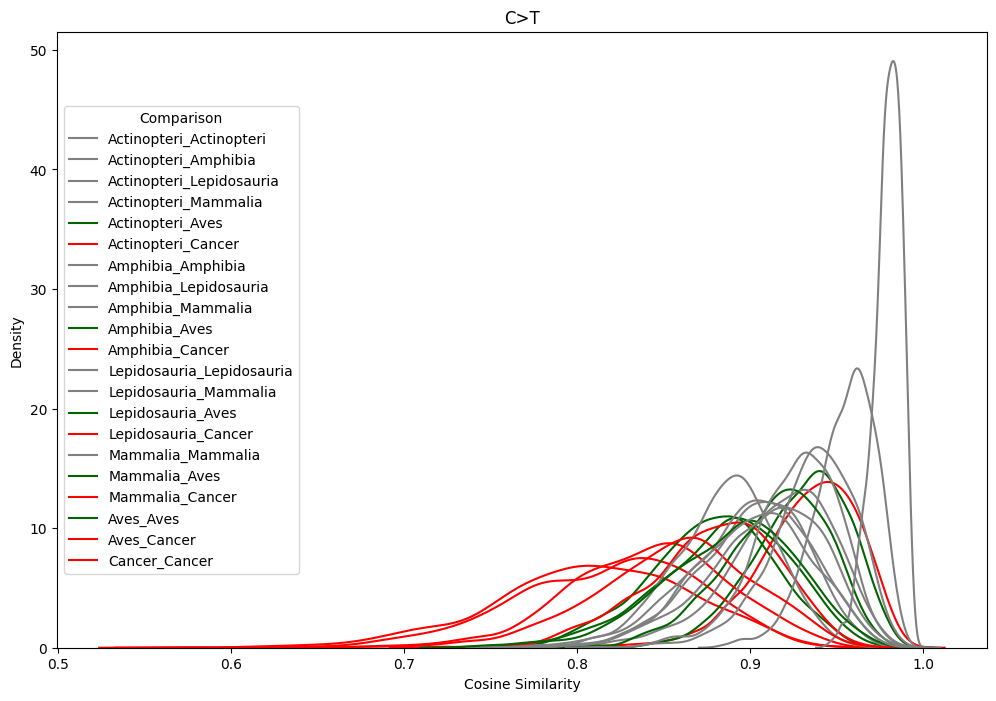

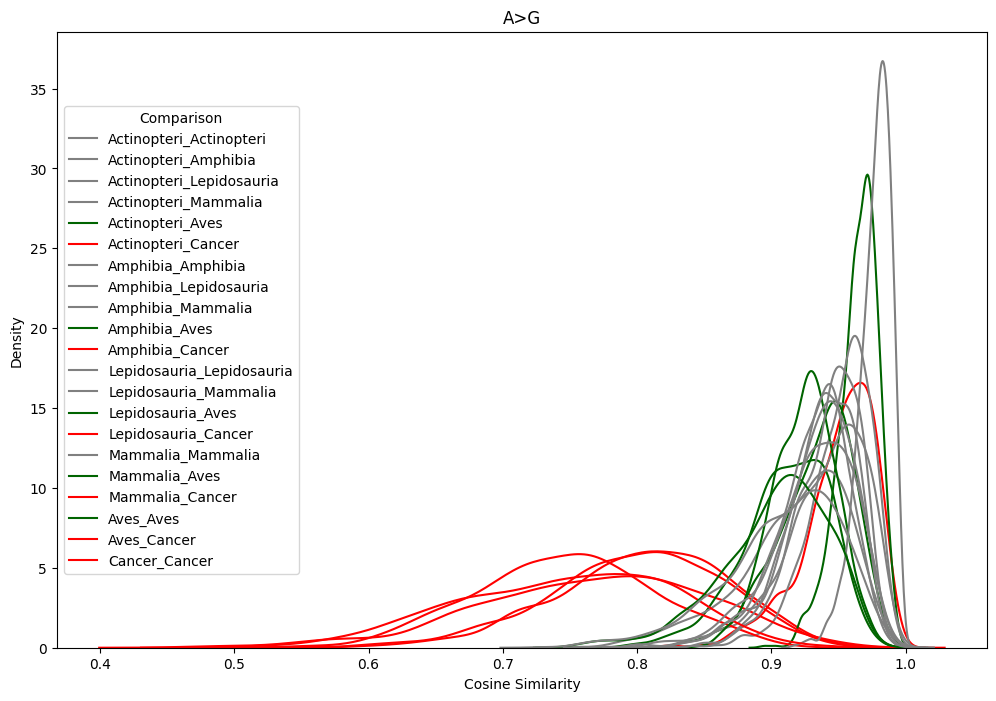

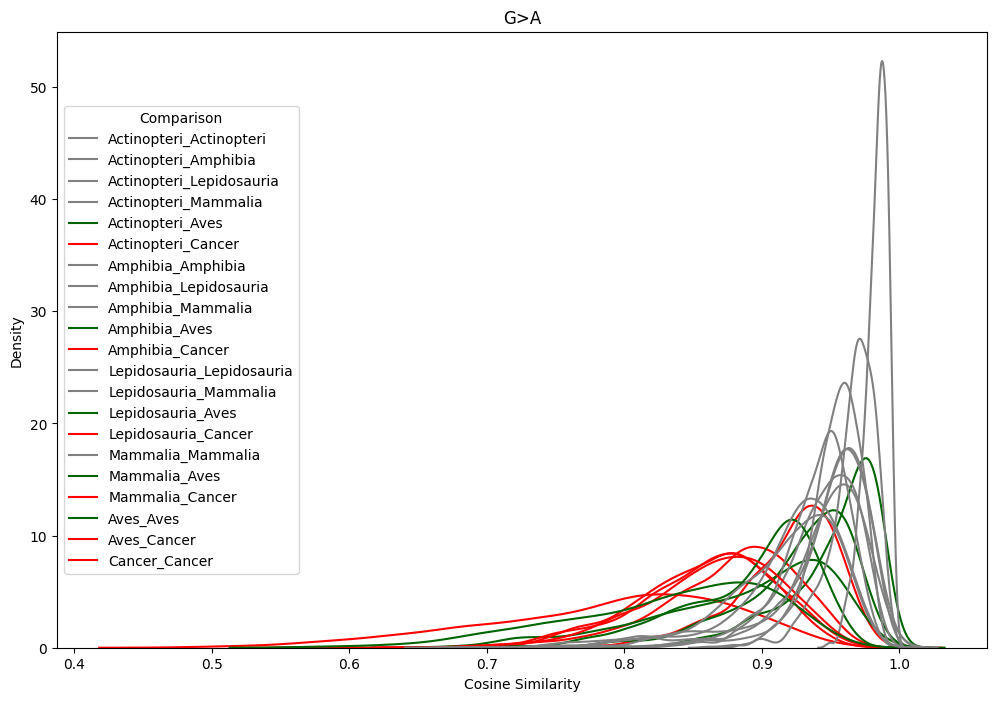

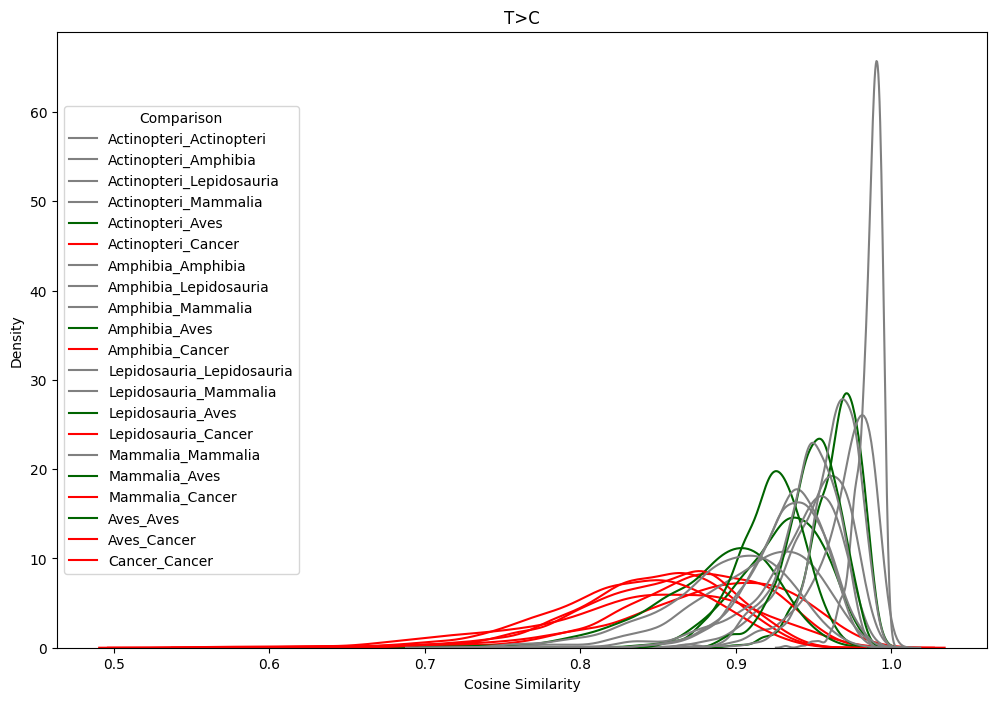

In [20]:
vec_of_subs_het = ['C>T', 'A>G', 'G>A', 'T>C']
for sub in tqdm.tqdm(vec_of_subs_het, 'Sub'):
    to_KDE = pd.read_csv(f'../data/CosSim{sub}.csv')
    to_KDE['Comparison'] = to_KDE.apply(lambda x: x.Class1 + '_' + x.Class2, axis=1)
    to_KDE = to_KDE.rename(columns={'Similarity': 'Cosine Similarity'})

    vec_comp_cls = to_KDE['Comparison'].drop_duplicates()
    col_map = {}
    for comp_un in vec_comp_cls:
        if re.search('Cancer', comp_un):
            col_map[comp_un] = 'red'
        elif re.search('Aves', comp_un):
            col_map[comp_un] = 'darkgreen'
        else:
            col_map[comp_un] = 'grey'    
        
    plt.figure(figsize=(12, 8))
    ax = sns.kdeplot(to_KDE, x='Cosine Similarity', hue='Comparison', common_norm=False,palette=col_map)
    ax.set_title(f'{sub}')
    sns.move_legend(ax, "center left")
    #plt.savefig(f'../pictures/HeatmapJack/KDE_plot_{sub}', dpi=300)

In [12]:
canc_df = pd.read_csv('../data/human_cancer_spectra_patient_specific_syn.csv')
canc_df = canc_df.drop(['nobs'], axis=1)
canc_df.head()

,sample,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,A[G>A]A,...,T[G>A]C,T[G>A]G,T[G>A]T,T[G>C]C,T[G>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]G
0,0007_CRUK_PC_0007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0064_CRUK_PC_0064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.009524,0.0,0.0,0.0,0.0
2,0071_CRUK_PC_0071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0078b0c4-68a9-483b-9aab-61156d263213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0082_CRUK_PC_0082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [13]:
for sbs in possible_sbs192_set:
    if sbs not in canc_df.columns:
        canc_df[sbs] = 0

In [14]:
canc_df = canc_df.melt(id_vars=['sample'], value_vars=canc_df.columns[1:])\
    .sort_values(by=['sample']).reset_index(drop=True)
canc_df = canc_df.rename(columns={'variable': 'Mut', 'value': 'MutSpec'})
canc_df['Class'] = 'Cancer'
#canc_df['Mut'] = canc_df.Mut.apply(getrevers)
canc_df['MutBase'] = canc_df['Mut'].str.get(2) + '>' + canc_df['Mut'].str.get(4)
canc_df.head()

,sample,Mut,MutSpec,Class,MutBase
0,0007_CRUK_PC_0007,A[A>G]A,0.0,Cancer,A>G
1,0007_CRUK_PC_0007,G[G>T]T,0.0,Cancer,G>T
2,0007_CRUK_PC_0007,G[A>T]G,0.0,Cancer,A>T
3,0007_CRUK_PC_0007,G[A>G]T,0.0,Cancer,A>G
4,0007_CRUK_PC_0007,A[A>C]G,0.0,Cancer,A>C


In [15]:
wrong_chain_cancer = get_similarity_table(mut_df=mut, canc_df=canc_df, mut_type='all', n_iter=1000)

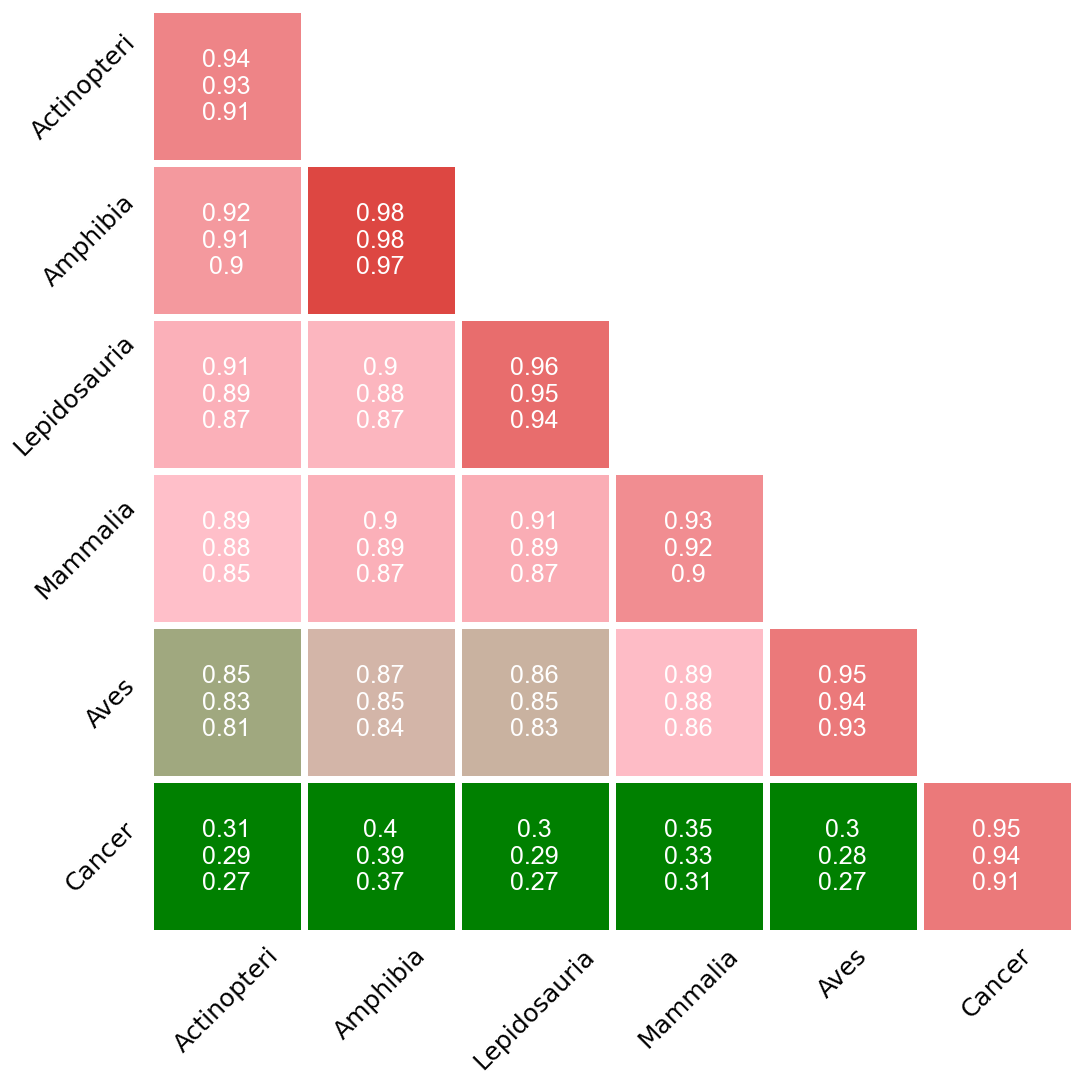

In [16]:
heatmap_similaruty(
    wrong_chain_cancer, title='', 
    #save_path='../pictures/HeatmapJack/Jackknife_SimilarityTS.pdf',
    # fontsize=36, labels_fontsize=28, titlesize=42, 
    vmin=0.75, vmax=1, cmap=custom_cmap, col_ht='w')